The aim in this notebook is to predict the total energy consumption in Germany using prediction time scales between 15 minutes and 24 hours.

First I import the needed python modules. 

In [3]:
import pandas as pd
import numpy as np
import scipy as sp

import time as time

import pmdarima as pm
from pmdarima.pipeline import Pipeline
from pmdarima.preprocessing import BoxCoxEndogTransformer

from datetime import date, time, datetime, timedelta

from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

import pickle

#add fullr and co 
import statsmodels.tsa.stattools as smtime

#We mainly use xgboost
from xgboost import XGBRegressor
import xgboost as xgb

#some skitlearn tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight

#trials
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import sklearn.metrics as met
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
#needs newest statsmodel 0.14.0 
from statsmodels.tsa.seasonal import MSTL
from functions import *

Now using different method to find best xgboost version

The data is obtained from https://www.smard.de/home/downloadcenter/download-marktdaten/?downloadAttributes=%7B%22selectedCategory%22:2,%22selectedSubCategory%22:false,%22selectedRegion%22:false,%22selectedFileType%22:false%7D
 using the category 'Stromverbrauch' then the subcategory 'realisierter Stromverbrauch', then 'Deutschland', then the subcategory time intervall 'viertelstunde'.
                   
            
That request gets the power consumption of Germany in the best possible resolution of 15 minutes. To get all availble data (nearly 8 years) it is needed to download in six pieces. 

In [9]:
#path to the data
path='/home/tobias/ml-testing/energy/'
#getting the data which is in four pieces
real_power1=pd.read_csv(path+"Realisierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
real_power4=pd.read_csv(path+"Realisierter_Stromverbrauch_201501010000_201611302359.csv",delimiter=';')
real_power3=pd.read_csv(path+"Realisierter_Stromverbrauch_201612010000_201811302359.csv",delimiter=';')
real_power2=pd.read_csv(path+"Realisierter_Stromverbrauch_201812010000_202011302359.csv",delimiter=';')
real_power5=pd.read_csv(path+"Realisierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')
real_power6=pd.read_csv(path+"Realisierter_Stromverbrauch_202401030000_202403112359_Viertelstunde.csv",delimiter=';')

Processing them. 

In [10]:
print(real_power5.columns)

Index(['Datum', 'Anfang', 'Ende',
       'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen',
       'Pumpspeicher [MWh] Originalauflösungen'],
      dtype='object')


In [11]:
processed1=prepare_input(real_power1,old=True,str_convert=False)
processed2=prepare_input(real_power2,old=True,str_convert=False)
processed3=prepare_input(real_power3,old=True,str_convert=False)
processed4=prepare_input(real_power4,old=True,str_convert=False)
processed5=prepare_input(real_power5,old=False,str_convert=True)
processed6=prepare_input(real_power6,old=False,str_convert=True)

/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:561: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['total_power'] = df['total_power'].str.replace('.','')
/home/tobias/ml-testing/energy/energy-timeseries/functions.py:558: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['residual_power'] = df['residual_power'].str.replace('.','')
/

Combine them and plot for checking. 

dimensions of the data are (315744, 6)


Text(0, 0.5, 'total power [GW]')

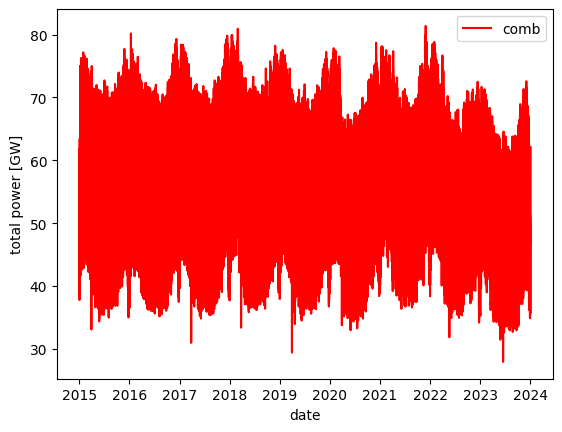

In [11]:
#date_time is set to index
processed1=processed1.set_index('date_time')
processed2=processed2.set_index('date_time')
processed3=processed3.set_index('date_time')
processed4=processed4.set_index('date_time')
processed5=processed5.set_index('date_time')
processed6=processed6.set_index('date_time')

#combining with concat
comb_real_power=pd.concat([processed4,processed3,2,real_power1,real_power5])
#reset index for easier handling
comb_real_power=comb_real_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape}")
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='comb') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

In this plot are visible that there are yearly variations, that the consumption is usually larger in winter than in summer. At the same time it is clear that there are variations also on smaller timescales, since the range at each date is large. That cannot really be variation at a time. To see more of them I zoom in on a week. 

(18604.0, 18611.0)

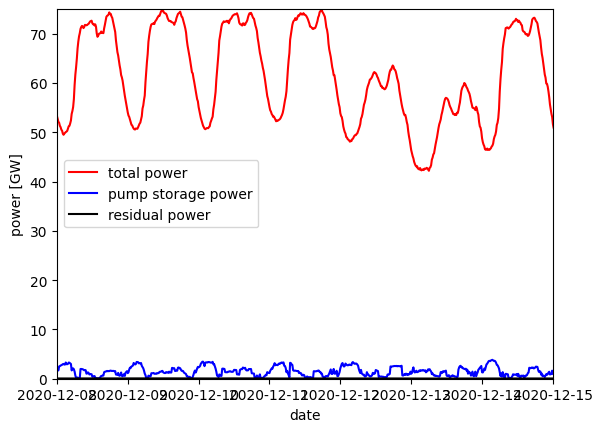

In [12]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0,75)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))

There are more cycles in the data, the strongest on the day time scale and likely another one on the time scale of a week. 

The periods are day, week and year.  From the 15 minutes sampling follows:

In [13]:
print(f"steps per day: {int(24*60/15)}")
print(f"steps per week: {int(7*24*60/15)}")
print(f"steps per year: {int(365.25*24*60/15)}")

steps per day: 96
steps per week: 672
steps per year: 35064




Below I look again on it this time use a logarithmic y-axis to be able to see more for the other two properties. 

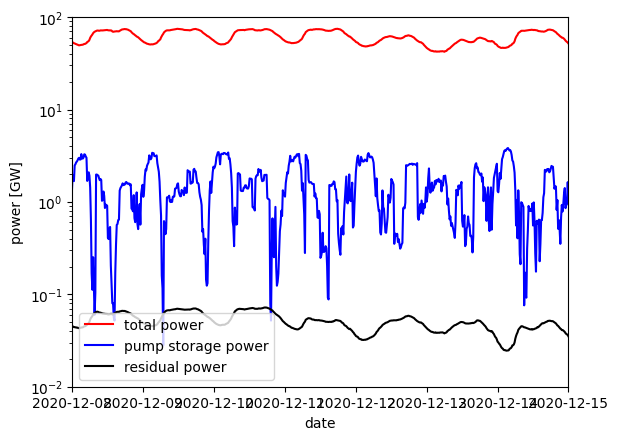

In [14]:
plt.plot(comb_real_power['date_time'],(comb_real_power['total_power']*4),'-',ms=1,color='red',label='total power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['pump_storage']*4/1000),'-',ms=1,color='blue',label='pump storage power') 
plt.plot(comb_real_power['date_time'],(comb_real_power['residual_power']*4/1000),'-',ms=1,color='black',label='residual power') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("power [GW]")
plt.ylim(0.01,100)
plt.xlim(datetime(2020, 12, 8),datetime(2020, 12, 15))
plt.yscale('log')


There is no clear connection of pump storage and residual power to total power and thus we ignore it for now.

As the next step we free space.

In [15]:
size_1=real_power1.shape[0]
size_2=real_power2.shape[0]
size_3=real_power3.shape[0]
size_4=real_power4.shape[0]
size_5=real_power5.shape[0]
real_power1=0
real_power2=0
real_power3=0
real_power4=0
real_power5=0

Now getting the offical predictions. 

In [16]:
pred_power1=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202012010000_202211142359.csv",delimiter=';')
pred_power4=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201501010000_201611302359_Viertelstunde.csv",delimiter=';')
pred_power3=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201612010000_201811302359_Viertelstunde.csv",delimiter=';')
pred_power2=pd.read_csv(path+"Prognostizierter_Stromverbrauch_201812010000_202011302359_Viertelstunde.csv",delimiter=';')
pred_power5=pd.read_csv(path+"Prognostizierter_Stromverbrauch_202211150000_202401022359_Viertelstunde.csv",delimiter=';')

Doing the same conversion as before. 

In [17]:
print(pred_power1.columns)
print(pred_power1.head())
print(pred_power5.columns)
print(pred_power5.head())
#slightly different column terms for coulms which will be different later
print(pred_power5.shape)
dic1b={'Datum':'Date','Uhrzeit':'Time','Gesamt (Netzlast)[MWh]':'total_power_pred','Residuallast[MWh]':'residual_power_pred'}

pred_power1.rename(columns=dic1b,inplace=True)
#here most different because onlyn now gotten
dic2b={'Datum':'Date','Anfang':'Time','Gesamt (Netzlast) [MWh] Originalauflösungen':'total_power_pred','Residuallast [MWh] Originalauflösungen':'residual_power_pred','Pumpspeicher [MWh] Originalauflösungen':'pump_storage'}
pred_power2.rename(columns=dic2b,inplace=True)
pred_power3.rename(columns=dic2b,inplace=True)
pred_power4.rename(columns=dic2b,inplace=True)
pred_power5.rename(columns=dic2b,inplace=True)
print("columns after dictionary application")
print(pred_power1.columns)
print("columns after dictionary application")
#drop columns
pred_power2.drop(['Ende'], axis=1, inplace=True)
pred_power3.drop(['Ende'], axis=1, inplace=True)
pred_power4.drop(['Ende'], axis=1, inplace=True)
pred_power5.drop(['Ende'], axis=1, inplace=True)
print(pred_power5.columns)
print(pred_power1.total_power_pred.value_counts())
print(pred_power2.total_power_pred.value_counts())
print(pred_power3.total_power_pred.value_counts())
print(pred_power4.total_power_pred.value_counts())
print(pred_power5.total_power_pred.value_counts())

Index(['Datum', 'Uhrzeit', 'Gesamt (Netzlast)[MWh]', 'Residuallast[MWh]'], dtype='object')
        Datum Uhrzeit  Gesamt (Netzlast)[MWh]  Residuallast[MWh]
0  01.12.2020   00:00                  12.944              7.608
1  01.12.2020   00:15                  12.771              7.491
2  01.12.2020   00:30                  12.667              7.453
3  01.12.2020   00:45                  12.541              7.403
4  01.12.2020   01:00                  12.370              7.319
Index(['Datum', 'Anfang', 'Ende',
       'Gesamt (Netzlast) [MWh] Originalauflösungen',
       'Residuallast [MWh] Originalauflösungen'],
      dtype='object')
        Datum Anfang   Ende Gesamt (Netzlast) [MWh] Originalauflösungen  \
0  15.11.2022  00:00  00:15                                   12.444,25   
1  15.11.2022  00:15  00:30                                   12.333,25   
2  15.11.2022  00:30  00:45                                   12.309,25   
3  15.11.2022  00:45  01:00                                

Some - no value, is reapced by 0 but most ignored later. 

In [18]:
#some are - no data I assume, thus not all can be used 
pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power3['residual_power_pred'] = pred_power3['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power3['residual_power_pred'] = pred_power3['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power3['total_power_pred'] = pred_power3['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power3['total_power_pred'] = pred_power3['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power4['residual_power_pred'] = pred_power4['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power4['residual_power_pred'] = pred_power4['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power4['total_power_pred'] = pred_power4['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power4['total_power_pred'] = pred_power4['total_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power5['residual_power_pred'] = pred_power5['residual_power_pred'].str.replace('.','').str.replace('-','0')
pred_power5['residual_power_pred'] = pred_power5['residual_power_pred'].str.replace(',','.').astype(float)/1000.
pred_power5['total_power_pred'] = pred_power5['total_power_pred'].str.replace('.','').str.replace('-','0')
pred_power5['total_power_pred'] = pred_power5['total_power_pred'].str.replace(',','.').astype(float)/1000.

/tmp/ipykernel_17855/2489085657.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power2['residual_power_pred'] = pred_power2['residual_power_pred'].str.replace('.','').str.replace('-','0')
/tmp/ipykernel_17855/2489085657.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power2['total_power_pred'] = pred_power2['total_power_pred'].str.replace('.','').str.replace('-','0')
/tmp/ipykernel_17855/2489085657.py:6: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  pred_power3['residual_power_pred'] = pred_power3['resi

In [19]:
pred_power1['date_time']=pd.to_datetime(pred_power1['Date'] + '.' + pred_power1['Time'], format='%d.%m.%Y.%H:%M')
pred_power2['date_time']=pd.to_datetime(pred_power2['Date'] + '.' + pred_power2['Time'], format='%d.%m.%Y.%H:%M')
pred_power3['date_time']=pd.to_datetime(pred_power3['Date'] + '.' + pred_power3['Time'], format='%d.%m.%Y.%H:%M')
pred_power4['date_time']=pd.to_datetime(pred_power4['Date'] + '.' + pred_power4['Time'], format='%d.%m.%Y.%H:%M')
pred_power5['date_time']=pd.to_datetime(pred_power5['Date'] + '.' + pred_power5['Time'], format='%d.%m.%Y.%H:%M')
print("The columns are")
print(pred_power1.columns)
print("data types of columns")
print(pred_power1.dtypes)
print(pred_power5.dtypes)

The columns are
Index(['Date', 'Time', 'total_power_pred', 'residual_power_pred', 'date_time'], dtype='object')
data types of columns
Date                           object
Time                           object
total_power_pred              float64
residual_power_pred           float64
date_time              datetime64[ns]
dtype: object
Date                           object
Time                           object
total_power_pred              float64
residual_power_pred           float64
date_time              datetime64[ns]
dtype: object


In [20]:
#date_time is set to index
pred_power1=pred_power1.set_index('date_time')
pred_power2=pred_power2.set_index('date_time')
pred_power3=pred_power3.set_index('date_time')
pred_power4=pred_power4.set_index('date_time')
pred_power5=pred_power5.set_index('date_time')
#combining with concat
comb_pred_power=pd.concat([pred_power4,pred_power3,pred_power2,pred_power1,pred_power5])
#reset index for easier handling
comb_pred_power=comb_pred_power.reset_index()
print(f"dimensions of the data are {comb_real_power.shape} and {comb_pred_power.shape}")
comb_real_power.loc[0:comb_pred_power.shape[0],['total_power_pred','residual_power_pred']]=comb_pred_power.loc[:,['total_power_pred','residual_power_pred']]
#free storage
pred_power1=0
pred_power2=0
pred_power3=0
pred_power4=0
pred_power5=0
comb_pred_power=0
print(f"dimensions of the data are {comb_real_power.shape} and {comb_pred_power}")

dimensions of the data are (315744, 6) and (315744, 5)
dimensions of the data are (315744, 8) and 0


Same shapes as they should be (will be differnt at some point when future official prediction is included.)
Now looking on goodness of prediction. 

Text(0, 0.5, 'total power [GW]')

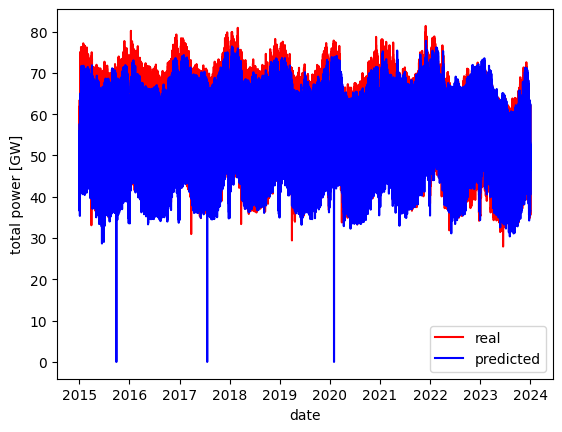

In [21]:
plt.plot(comb_real_power['date_time'],comb_real_power['total_power']*4,'-',ms=1,color='red',label='real') 
plt.plot(comb_real_power['date_time'],comb_real_power['total_power_pred']*4,'-',ms=1,color='blue',label='predicted') 
plt.legend(loc="best")
plt.xlabel("date")
plt.ylabel("total power [GW]")

Some rather random times with no data. Excludeded for statistic. 

In [18]:
print(comb_real_power[(comb_real_power.total_power_pred!=0)].total_power.describe())
print(comb_real_power[(comb_real_power.total_power_pred!=0)].total_power_pred.describe())
print(((comb_real_power[(comb_real_power.total_power_pred!=0)].total_power-comb_real_power[(comb_real_power.total_power_pred!=0)].total_power_pred)/comb_real_power[(comb_real_power.total_power_pred!=0)].total_power).describe())

count    315360.000000
mean         14.101984
std           2.501620
min           6.984750
25%          12.042000
50%          14.019000
75%          16.195000
max          20.342000
Name: total_power, dtype: float64
count    315360.000000
mean         13.701217
std           2.356878
min           7.168750
25%          11.776250
50%          13.681375
75%          15.705000
max          19.438000
Name: total_power_pred, dtype: float64
count    315360.000000
mean          0.026633
std           0.042978
min          -0.380062
25%           0.001922
50%           0.029544
75%           0.054010
max           0.271257
dtype: float64


4.5% standard deviation, 5.5% interquartile range for the prediction also in average 3% too small, thus not prefect prediction. 
Adding fractions used unit columns now. 

In [23]:
time1=np.zeros((comb_real_power.shape[0],5))
for i in range(comb_real_power.shape[0]):
    time1[i,0]=i/4/24
    time1[i,1]=time1[i,0]%1
    time1[i,2]=(time1[i,0]%7)/7
    time1[i,3]=(time1[i,0]%365.25)/365.25
    time1[i,4]=i/4/24/365.25  
print(time1)    
comb_real_power['frac_day']=time1[:,1]
comb_real_power['frac_week']=time1[:,2]
comb_real_power['frac_year']=time1[:,3]

print(comb_real_power.describe())
#later also real daya and easter but for now just using the current model to predict

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [1.04166667e-02 1.04166667e-02 1.48809524e-03 2.85192790e-05
  2.85192790e-05]
 [2.08333333e-02 2.08333333e-02 2.97619048e-03 5.70385581e-05
  5.70385581e-05]
 ...
 [3.28896875e+03 9.68750000e-01 8.52678571e-01 4.70568104e-03
  9.00470568e+00]
 [3.28897917e+03 9.79166667e-01 8.54166667e-01 4.73420032e-03
  9.00473420e+00]
 [3.28898958e+03 9.89583333e-01 8.55654762e-01 4.76271960e-03
  9.00476272e+00]]
         total_power  residual_power   pump_storage  total_power_pred  \
count  315744.000000   315744.000000  315744.000000     315744.000000   
mean       14.101555        9.885544     207.012504         13.684554   
std         2.501696       13.365981     264.747801          2.403361   
min         6.984750       -1.545000       0.000000          0.000000   
25%        12.042000        7.574000       1.637437         11.770500   
50%        14.017625        9.799000      76.000000         13.676500   
75%

 I choose for fitting the two efficient options XGBoost regressor and linear regression. 

Xgboost needs to have the data transformed into the usual supervised data structure. Therefore, I use a function which uses some continous data block to predict one future data point. There can be a gap between the used data and the predicted data point or no gap. 

In [20]:
#parameters are: 
#data_frame, number of data points used for prediction, number of data points ignored between data and target, nan excluding
def series_to_supervised(data, n_in=1, offset=0, dropnan=True):
    #create empty data frame and list
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t+offset)
    for i in range(offset, 1+offset):
        cols.append(df.shift(-i))
    # connecting all 
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

I construct a function for this purpose.  Since the fitting takes time the result is saved.

In [21]:
#parameters, data, min time pred period in hours/4-1/4, max-min time pred peiod in hours/4-1/4, predictining over how many data_points
#steps in test, model shortcut used, name of file for output
def predict_intervall(df,a,b,c,d,model,output):
    resf=np.zeros((4,b))
    #valid_modelchecks whether model is called
    valid_model=False
    if model=="xgb" or model=="xgboost":
        xmodel3=XGBRegressor()
        print("running XGBoost")
        valid_model=True
    if model=="lin" or model=='linear':
        xmodel3=LinearRegression()
        print("running Linear Regression")
        valid_model=True
    if valid_model==True:
        for i in range(int(a), int(b+a)):
            print(f"running prediction over {(i+1)*15} minutes")
            #convert to supervised data format
            res3=series_to_supervised(df.total_power,c,i)
            res3=pd.DataFrame(res3)
            #split in test and train
            dataa3_train = res3.iloc[:-d,:]
            dataa3_test  = res3.iloc[-d:,:]
            x3_train=dataa3_train.iloc[:,:c]
            x3_test=dataa3_test.iloc[:,:c]
            y3_train=dataa3_train.iloc[:,c]
            y3_test=dataa3_test.iloc[:,c]
            #time scale of prediction
            resf[0,i-int(a)]=15*(i+1)
            #fit and predict
            xmodel3.fit(x3_train,y3_train)
            pred3=xmodel3.predict(x3_test)
            #standard deviation of prediction
            resf[2,i-int(a)]=np.std(pred3-y3_test)
            #compare with shift
            diff6=y3_test.shift(periods=i+1)           
            resf[1,i-int(a)]=np.std(diff6-y3_test)
            #mean value to get percentage
            resf[3,i-int(a)]=np.mean(y3_test)
    else:
        print("no implemented model called")
    np.savetxt(output,resf)

Now making new predictions with XGBoost using day and week day plus for now just the production one day ago as features. Year for now omitted, less fraction and 365 to 3666 causes problems. 

In [22]:
#first now then to predict, here the 96 will be varies to get for many periods 
ser=series_to_supervised(comb_real_power.total_power,1,96)
print(ser.shape,ser[0:10,0:10])

(315647, 2) [[11.21  11.306]
 [11.119 11.019]
 [11.145 10.877]
 [11.127 10.818]
 [11.01  10.687]
 [10.923 10.616]
 [10.817 10.55 ]
 [10.705 10.5  ]
 [10.65  10.451]
 [10.547 10.405]]


Add to it time. 

In [23]:
df_ser=pd.DataFrame(ser,columns=["now","to_predict"])

In [24]:
print(df_ser)
print(df_ser.shape,comb_real_power.shape)
df_ser.loc[:,'frac_day']=comb_real_power.loc[0:df_ser.shape[0],'frac_day']
df_ser.loc[:,'frac_week']=comb_real_power.loc[0:df_ser.shape[0],'frac_week']
df_ser.loc[:,'frac_year']=comb_real_power.loc[0:df_ser.shape[0],'frac_year']

            now  to_predict
0       11.2100    11.30600
1       11.1190    11.01900
2       11.1450    10.87700
3       11.1270    10.81800
4       11.0100    10.68700
...         ...         ...
315642  10.7365    12.50175
315643  10.5570    12.29050
315644  10.4200    12.09550
315645  10.2275    11.83150
315646  10.0850    11.72175

[315647 rows x 2 columns]
(315647, 2) (315744, 11)


In [25]:
print(df_ser.columns)
frac1=int(df_ser.shape[0]*0.8)
print(frac1)
ser_train=df_ser.iloc[:frac1,:]
ser_test=df_ser.iloc[frac1:,:]

Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
252517


In [26]:
xmodel1=XGBRegressor().fit(ser_train.loc[:,['now','frac_day', 'frac_week']],ser_train.loc[:,'to_predict'])
pred1=xmodel1.predict(ser_test.loc[:,['now','frac_day', 'frac_week']])


Looking on metrics. 

In [27]:
print(((pred1-ser_test.to_predict)/np.mean(ser_test.to_predict)).describe())

count    63130.000000
mean         0.008394
std          0.051455
min         -0.306773
25%         -0.018206
50%          0.005467
75%          0.031273
max          0.409365
Name: to_predict, dtype: float64


Standard deviation 5.15%. MTSL is 3.79% but trained on itself. Using residua in linear regression in addition improves by about 7% on day time scale. The official prediction is about 4.3% precision. Not extatcly the same time frame is used for the caluclations.  

Now using also year. 

In [28]:
xmodel2=XGBRegressor().fit(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.loc[:,'to_predict'])
pred2=xmodel2.predict(ser_test.loc[:,['now','frac_day', 'frac_week','frac_year']])


In [29]:
print(((pred2-ser_test.to_predict)/np.mean(ser_test.to_predict)).describe())

count    63130.000000
mean         0.018921
std          0.043792
min         -0.300694
25%         -0.004228
50%          0.018230
75%          0.042007
max          0.391043
Name: to_predict, dtype: float64


Clearly better now 4.4%.  
Looking on feature importance. 

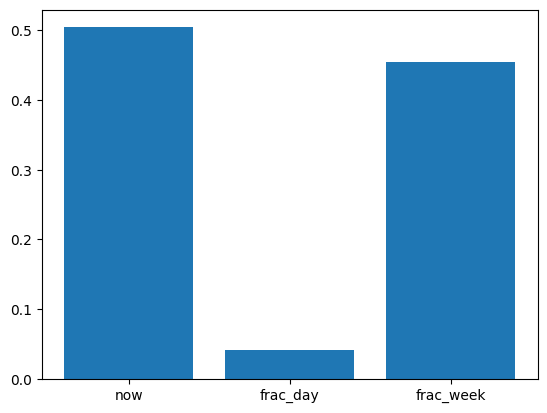

In [30]:
plt.bar(ser_train.loc[:,['now','frac_day', 'frac_week']].columns, xmodel1.feature_importances_)
plt.show()

Fraction of day is not important, probably its prediction properrties are similar as current state. 

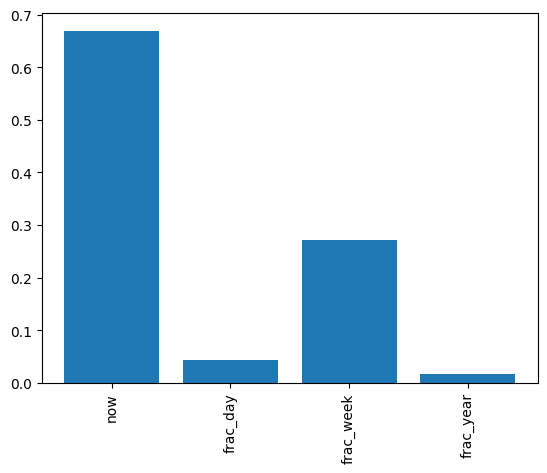

In [31]:
plt.bar(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']].columns, xmodel2.feature_importances_)
plt.xticks(rotation = 90)
plt.show()

When year is added actually year does not matter much buts makes frac week less important. 

Netx options, try some grid. Try more precursor data, likely average of several, since when a day is in between exatcly before does not matter so much. 

In [32]:
from ib_functions_ml import *

In [88]:
loop_reg(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=40,file_name='xgb_4_v1.txt',regression=True,silent=False)

doing case 0
xgb took 3.0674 seconds
standard deviation of test 2.2523 points
standard deviation of train 2.5151  points
standard deviation of prediction-test 0.5748 points
standard deviation of prediction-train 0.4702 points
doing case 1
xgb took 2.8271 seconds
standard deviation of test 2.2523 points
standard deviation of train 2.5151  points
standard deviation of prediction-test 0.5669 points
standard deviation of prediction-train 0.4683 points
doing case 2
xgb took 2.8587 seconds
standard deviation of test 2.2523 points
standard deviation of train 2.5151  points
standard deviation of prediction-test 0.5668 points
standard deviation of prediction-train 0.4683 points
doing case 3
xgb took 2.8919 seconds
standard deviation of test 2.2523 points
standard deviation of train 2.5151  points
standard deviation of prediction-test 0.5669 points
standard deviation of prediction-train 0.4683 points
doing case 4
xgb took 2.9615 seconds
standard deviation of test 2.2523 points
standard deviation

xgb took 4.8555 seconds
standard deviation of test 2.2523 points
standard deviation of train 2.5151  points
standard deviation of prediction-test 0.5862 points
standard deviation of prediction-train 0.5315 points
doing case 38
xgb took 4.9794 seconds
standard deviation of test 2.2523 points
standard deviation of train 2.5151  points
standard deviation of prediction-test 0.5915 points
standard deviation of prediction-train 0.545 points
doing case 39
xgb took 4.308 seconds
standard deviation of test 2.2523 points
standard deviation of train 2.5151  points
standard deviation of prediction-test 0.6309 points
standard deviation of prediction-train 0.5707 points


Text(0.5, 1.0, '4 features')

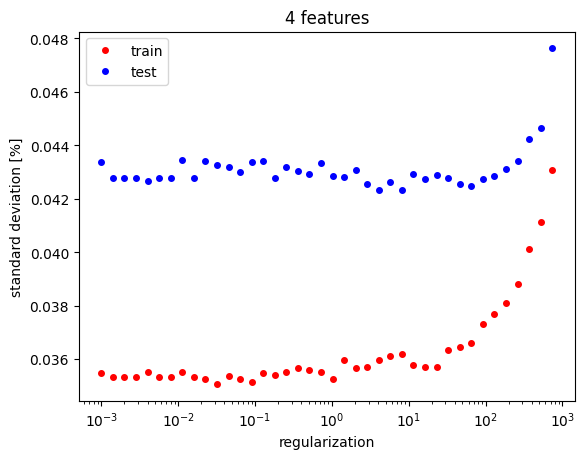

In [45]:
x1=np.loadtxt('xgb_4_v1.txt')


plt.plot(x1[0],x1[2]/np.mean(ser_test.to_predict),'o',ms=4,color='red',label="train")  
plt.plot(x1[0],x1[3]/np.mean(ser_test.to_predict),'o',ms=4,color='blue',label="test")  
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("regularization")
plt.ylabel("standard deviation [%]")
plt.xscale("log")
plt.title("4 features")

Some imporve,ent but not yet clear that it is the optimum. Also noisy, thus should fit it with parabola to use the best one.   Needs to divide by std test to get usual. A little better then about 4.05%. 

Function to find minimum. 

In [89]:
#quadrtyic logarithm
def log_quat(x,a,b,c):
    return a+b*np.log10(x)+c*np.log10(x)**2

In [90]:
def dev_quat(a,b,c):
    return -b/(2*c)
    

In [91]:
def find_best(dat,delta=3):
    min_p=np.argmin(dat[3])
    est=np.zeros((3))
    print(dat[0,min_p])
    print(dat[0:4,min_p-delta:min_p+delta])
    if min_p-delta>=0:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,min_p-delta:min_p+delta],dat[3,min_p-delta:min_p+delta],p0=est)
    else:
        val,cov=sp.optimize.curve_fit(log_quat,dat[0,0:min_p+delta],dat[3,0:min_p+delta],p0=est)
    print(val)
    min_p1=10**dev_quat(val[0],val[1],val[2])
    return min_p1
    

In [49]:
a=log_quat(10,0,1,2)
print(a)
best_reg=find_best(x1,delta=4)

3.0
4.0811807269213
[[ 1.02091172  1.44356917  2.04120681  2.88626643  4.08118073  5.77078955
   8.15989642 11.53809354]
 [ 4.          4.          4.          4.          4.          4.
   4.          4.        ]
 [ 0.46721099  0.47649101  0.47238429  0.47309713  0.47664354  0.47848415
   0.47963171  0.47402545]
 [ 0.56785682  0.56704723  0.57060385  0.56394261  0.56056985  0.5646941
   0.56097686  0.56867295]]
[ 0.56992589 -0.01918939  0.01453615]


In [50]:
xmodel3=XGBRegressor(alpha=best_reg).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
xmodel3.save_model("xgb_model_096.json")


In [39]:
xmodel4=XGBRegressor()
xmodel4.load_model("xgb_model_096.json")

Basic works, now making all to a function that it can be produced for a number of time deltas. 
First for single time delta. 

Should give out standard deviation of test at some point also. 

In [92]:
#parameters data frame, gap to wanted prediction
def find_fit_best_reg(df,gap,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True):
    ser=series_to_supervised(df.total_power,now_points,gap)
    df_ser=pd.DataFrame(ser,columns=["now","to_predict"])
    df_ser.loc[:,'frac_day']=df.loc[0:df_ser.shape[0],'frac_day']
    df_ser.loc[:,'frac_week']=df.loc[0:df_ser.shape[0],'frac_week']
    df_ser.loc[:,'frac_year']=df.loc[0:df_ser.shape[0],'frac_year']
    print(df_ser.shape)
    print(df_ser.columns)
    frac1=int(df_ser.shape[0]*0.8)
    print(frac1)
    ser_train=df_ser.iloc[:frac1,:]
    ser_test=df_ser.iloc[frac1:,:]
    print(reg_steps)
    stat_reg=loop_reg(ser_train.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_train.to_predict,ser_test.loc[:,['now','frac_day', 'frac_week', 'frac_year']],ser_test.to_predict,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,Save=False,regression=True,silent=False)
    print(stat_reg)
    best_reg=find_best(stat_reg,delta=delta)
    xmodel=XGBRegressor(alpha=best_reg).fit(df_ser.loc[:,['now','frac_day', 'frac_week', 'frac_year']],df_ser.loc[:,'to_predict'])
    if save==True:
        xmodel.save_model(filename)
    else:
        return xmodel

In [44]:
find_fit_best_reg(comb_real_power,0,reg_steps=40,filename="xgb_model_000.json")

(315743, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
252594
40
doing case 0
xgb took 4.359 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.0923 points
standard deviation of prediction-train 0.0783 points
doing case 1
xgb took 4.0691 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.0917 points
standard deviation of prediction-train 0.0778 points
doing case 2
xgb took 3.8037 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.093 points
standard deviation of prediction-train 0.0776 points
doing case 3
xgb took 3.887 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.094 points
standard deviation of prediction-train 0.0797 po

xgb took 4.5944 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.1144 points
standard deviation of prediction-train 0.111 points
doing case 37
xgb took 3.8193 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.1235 points
standard deviation of prediction-train 0.1216 points
doing case 38
xgb took 3.5056 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.1294 points
standard deviation of prediction-train 0.1283 points
doing case 39
xgb took 3.4645 seconds
standard deviation of test 2.2524 points
standard deviation of train 2.5154  points
standard deviation of prediction-test 0.1388 points
standard deviation of prediction-train 0.14 points
[[1.00000000e-03 1.41400000e-03 1.99939600e-03 2.82714594e-03
  3.99758436e-03 5.65258429e-03 7.99275419e-03 

In [ ]:
Seems to work. 

Make function to many of them. 

In [93]:
def fit_many_gaps(df,gap_start=1,gap_steps=2,now_points=1,test_frac=0.8,max_depth=4,reg_start=0.001,reg_increase=1.414,reg_steps=4,delta=4,filename=None,save=True):
    for i in range(gap_steps):
        gap=gap_start+i
        print(gap)
        if gap<10:
            filename="xgb_model_00"+str(gap)+".json"
        elif gap<100:
            filename="xgb_model_0"+str(gap)+".json"
        elif gap<1000:
            filename="xgb_model_"+str(gap)+".json"            
        find_fit_best_reg(df,gap,now_points=now_points,test_frac=test_frac,max_depth=max_depth,reg_start=reg_start,reg_increase=reg_increase,reg_steps=reg_steps,delta=delta,filename=filename,save=True)

In [120]:
#9:37 start finish before 9:43 for 2
# for 10 start at 9:45 finish 10:17
#now running enough for 2 day prediction 
fit_many_gaps(comb_real_power,reg_steps=40,reg_start=0.0012,gap_start=44,gap_steps=1)

44
(315699, 5)
Index(['now', 'to_predict', 'frac_day', 'frac_week', 'frac_year'], dtype='object')
252559
40
doing case 0
xgb took 3.3086 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6144 points
standard deviation of prediction-train 0.4729 points
doing case 1
xgb took 2.8862 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6144 points
standard deviation of prediction-train 0.4729 points
doing case 2
xgb took 3.0695 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6144 points
standard deviation of prediction-train 0.4729 points
doing case 3
xgb took 2.9256 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6144 points
standard deviation of prediction-train 0.4729

xgb took 4.4128 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6393 points
standard deviation of prediction-train 0.5212 points
doing case 37
xgb took 4.6599 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6477 points
standard deviation of prediction-train 0.5309 points
doing case 38
xgb took 4.585 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.648 points
standard deviation of prediction-train 0.5432 points
doing case 39
xgb took 4.5557 seconds
standard deviation of test 2.2525 points
standard deviation of train 2.515  points
standard deviation of prediction-test 0.6625 points
standard deviation of prediction-train 0.5566 points
[[1.20000000e-03 1.69680000e-03 2.39927520e-03 3.39257513e-03
  4.79710124e-03 6.78310115e-03 9.59130503e-03 1.3

Next make function which can predict flux from the now data point into the future. 

In [121]:
#parameters, most recent features, list of model,delta ts, standard is just every 0.25 h from models
def predict_from_now(data,models,deltas=None):
    print(data)
    if deltas==None:
        deltas=np.zeros((len(models)))
        for i in range(len(models)):
            deltas[i]=0.25+i/4
    res=np.zeros((3,len(models)))  
    res[0,:]=deltas
    for i in range(len(models)):
        print(i)
        xmodel=XGBRegressor()
        xmodel.load_model(models[i])
        #predict needs more than 1 data point to work 
        res[1,i]=xmodel.predict(data)[-1]
    #need better column names at some points in a data frame     
    return res     

In [22]:
print(comb_real_power.loc[comb_real_power.shape[0]-1,['total_power','frac_day', 'frac_week', 'frac_year']])
myPath='/home/tobias/ml-testing/energy/energy-timeseries'
models=[f for f in os.listdir(myPath) 
    if (f.startswith('xgb_model_')) and  (f.endswith('json') )] 
models.sort()
print(models)

KeyError: "['frac_day', 'frac_week', 'frac_year'] not in index"

In [123]:
prediction=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0],['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741     12.09550  0.968750   0.852679   0.004706
315742     11.83150  0.979167   0.854167   0.004734
315743     11.72175  0.989583   0.855655   0.004763
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


In [124]:
prediction2=predict_from_now(comb_real_power.loc[comb_real_power.shape[0]-3:comb_real_power.shape[0]-2,['total_power','frac_day', 'frac_week', 'frac_year']],models[:])

        total_power  frac_day  frac_week  frac_year
315741      12.0955  0.968750   0.852679   0.004706
315742      11.8315  0.979167   0.854167   0.004734
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191


Seems to work and relatively fast, likely fats enough for doing it every 15 mimnutes.
Not crazy fast but good enough for now. 

[[11.         16.05557632]
 [11.25       16.3004055 ]
 [11.5        16.71058273]
 [11.75       16.44300652]
 [12.         16.55988121]
 [12.25       16.55244637]
 [12.5        16.56935883]]


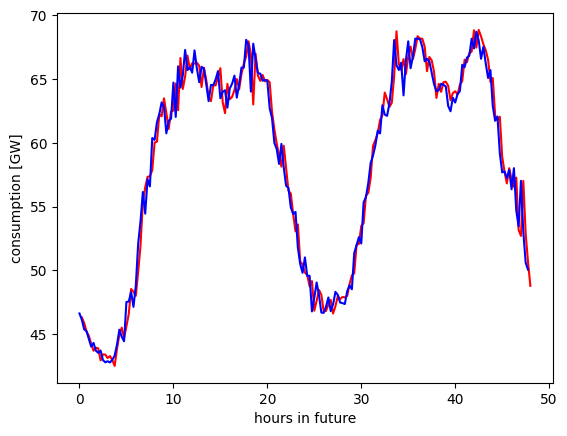

In [125]:
plt.plot(prediction[0],prediction[1]*4,color='red')
plt.plot(prediction2[0]-0.25,prediction2[1]*4,color='blue')
plt.xlabel("hours in future")
plt.ylabel("consumption [GW]")    
print(prediction[0:2,43:50].T)

LOoks plausible mostly, also not with much wiggles, but one is rather bad close to 10 hours. 
That seem to be general bad, rerun withg 20% offset regularization start. That solved the problem, others are more like noise without a clear wrong solution. 
Those wiggles are a kind of noise not really expected, whether bad depends on whether it should look better as it is or not. 

Still looks good that it can be implemented. 

## Further improvement ideas
- Need track metrics 
- Start year on 1 march because of 29 February.
- Add something special datawise for days infleunces by eastern, could be in main models or in special model only used sometimes
- Add more past (possible average) data points
